# 手撕Transformer
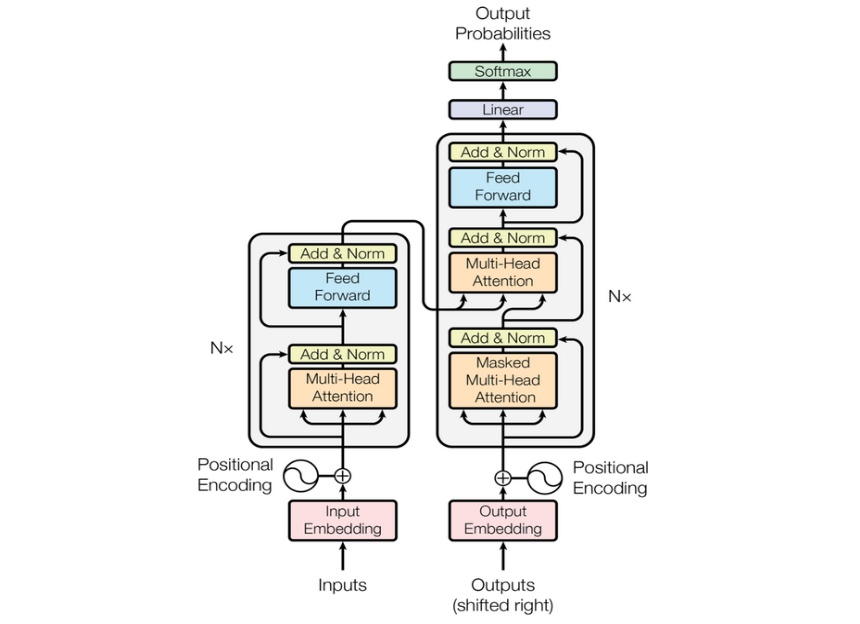

## 一、文本嵌入层
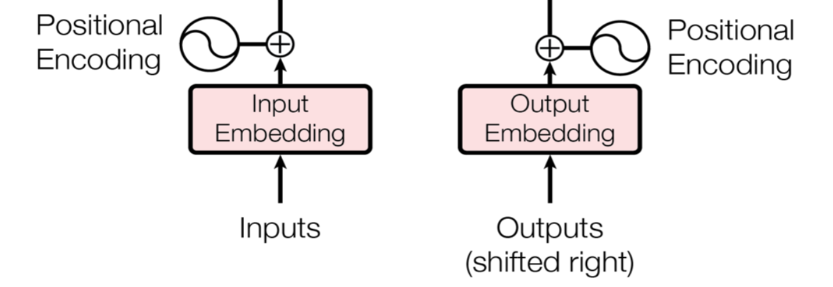
- **文本嵌入层的作用**

    - 无论是源文本嵌入还是目标文本嵌入，都是为了将文本中词汇的数字表示转变为向量表示, 希望在这样的高维空间捕捉词汇间的关系

- **文本嵌入层代码分析**

In [54]:
# 导入必备的工具包
import torch
 
# 预定义的网络层torch.nn, 工具开发者已经帮助我们开发好的一些常用层, 
# 比如，卷积层, lstm层, embedding层等, 不需要我们再重新造轮子.
import torch.nn as nn
 
# 数学计算工具包
import math
 
# torch中变量封装函数Variable.
from torch.autograd import Variable
 
# 定义Embeddings类来实现文本嵌入层，这里s说明代表两个一模一样的嵌入层, 他们共享参数.
# 该类继承nn.Module, 这样就有标准层的一些功能, 这里我们也可以理解为一种模式, 我们自己实现的所有层都会这样去写.
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        """类的初始化函数, 有两个参数, d_model: 指词嵌入的维度, vocab: 指词表的大小."""
        # 接着就是使用super的方式指明继承nn.Module的初始化函数, 我们自己实现的所有层都会这样去写.
        super(Embeddings, self).__init__()
        # 之后就是调用nn中的预定义层Embedding, 获得一个词嵌入对象self.lut
        self.lut = nn.Embedding(vocab, d_model)
        # 最后就是将d_model传入类中
        self.d_model = d_model
 
    def forward(self, x):
        """可以将其理解为该层的前向传播逻辑，所有层中都会有此函数
           当传给该类的实例化对象参数时, 自动调用该类函数
           参数x: 因为Embedding层是首层, 所以代表输入给模型的文本通过词汇映射后的张量"""
 
        # 将x传给self.lut并与根号下self.d_model相乘作为结果返回
 
        # 让 embeddings vector 在增加 之后的 postion encoing 之前相对大一些的操作，
        # 主要是为了让position encoding 相对的小，这样会让原来的 embedding vector 中的信息在和 position encoding 的信息相加时不至于丢失掉
        # 让 embeddings vector 相对大一些
        return self.lut(x) * math.sqrt(self.d_model)

- **nn.Embedding演示**

In [55]:
embedding = nn.Embedding(10, 3)
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input)

tensor([[[ 1.6952e+00,  2.8157e-01, -7.4975e-02],
         [ 1.2106e+00, -5.6524e-01, -4.7502e-01],
         [ 4.5174e-01,  3.9740e-01, -2.4363e-01],
         [-1.8766e-01,  7.3676e-01, -1.3513e+00]],

        [[ 4.5174e-01,  3.9740e-01, -2.4363e-01],
         [ 9.3767e-04,  2.1447e+00, -1.2154e+00],
         [ 1.2106e+00, -5.6524e-01, -4.7502e-01],
         [-4.5715e-01,  3.2418e-01,  1.1887e+00]]],
       grad_fn=<EmbeddingBackward0>)

In [56]:
embedding = nn.Embedding(10, 3, padding_idx=2)
input = torch.LongTensor([[0,2,0,5]])
embedding(input)

tensor([[[ 0.4996,  0.2529,  1.2497],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.4996,  0.2529,  1.2497],
         [-0.7523,  0.1728, -1.3204]]], grad_fn=<EmbeddingBackward0>)

- **实例化参数**

In [57]:
# 词嵌入维度是512
d_model = 512
# 词表大小是1000
vocab = 1000

- **输入参数**

In [58]:
# 输入x是一个使用Variable封装的长整型张量, 形状是2 x 4
x = Variable(torch.LongTensor([[100,2,421,508],[491,998,1,221]]))

- **调用与输出效果**

In [59]:
emb = Embeddings(d_model, vocab)
embr = emb(x)
print("embr:", embr)
print(embr.shape)

embr: tensor([[[ -4.6697,  -6.0534,  -5.2668,  ..., -11.8735, -23.0159,  27.3322],
         [  6.8467,  -3.4305,   3.6786,  ..., -19.7740, -31.9720, -12.3351],
         [  5.6094,   6.1216, -22.5410,  ...,   0.9803, -12.8439, -13.4272],
         [  6.2610,  12.3505,  15.3085,  ...,  16.1466, -35.5486,  32.2648]],

        [[-13.3856,  14.7171,  37.0112,  ...,   6.0940, -14.2405,   3.0835],
         [  8.0704, -10.3653, -29.4992,  ..., -31.5887, -48.9371, -10.0452],
         [  7.3509, -23.5942, -10.4161,  ...,  43.9306, -13.3478,  14.1981],
         [ -9.7556, -10.3625, -39.2270,  ...,   3.4950, -17.3911, -12.7946]]],
       grad_fn=<MulBackward0>)
torch.Size([2, 4, 512])


## 二、位置编码
位置编码(Positional Encoding)是[Transformer](https://gitcode.com/gh_mirrors/tr/transformer/overview?utm_source=highlight_word_gitcode&word=transformer&isLogin=1)模型中的一个重要组成部分，用于在序列数据中引入位置信息。由于Transformer模型本身不具备处理序列顺序的能力（因为它完全基于自注意力机制，没有递归或卷积结构），位置编码的引入是的模型能够利用序列的顺序信息。

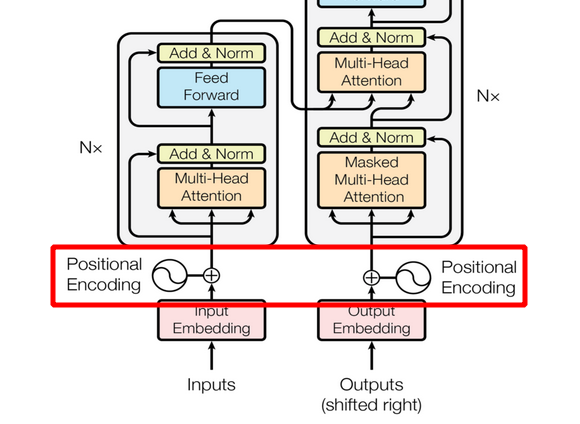

**位置编码的原理**
位置编码通过输入嵌入向量中添加一个与位置相关的向量来实现。具体来说，对于每一个位置($pos$)和每个维度($i$)，位置编码向量($PE\left(pos,2i\right)$)和($PE\left(pos,2i+1\right)$)分别由以下公式计算


$$
\begin{aligned}
PE\left(pos,2i\right)&=sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)\\
PE\left(pos,2i+1\right)&=cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
\end{aligned}
$$
其中$d_{model}$是模型的维度，$pos$是位置，$i$是维度索引

**代码解释**
以下是`PositionalEncoder`

In [85]:
import torch
import torch.nn as nn
import math
# 定义位置编码器类, 我们同样把它看做一个层, 因此会继承nn.Module    
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, dropout, max_seq_len=5000):
        """位置编码器类的初始化函数, 共有三个参数, 分别是d_model: 词嵌入维度, 
        dropout: 置0比率, max_len: 每个句子的最大长度"""
        super().__init__()
        # 实例化nn中预定义的Dropout层, 并将dropout传入其中, 获得对象self.dropout
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        # 初始化一个位置编码矩阵, 它是一个0阵，矩阵的大小是max_seq_len x d_model
        pe = torch.zeros(max_seq_len, d_model)
        # 初始化一个绝对位置矩阵, 在我们这里，词汇的绝对位置就是用它的索引去表示. 
        # 所以我们首先使用arange方法获得一个连续自然数向量，然后再使用unsqueeze方法拓展向量维度使其成为矩阵， 
        # 又因为参数传的是1，代表矩阵拓展的位置，会使向量变成一个max_len x 1 的矩阵，
        position = torch.arange(0, max_seq_len).unsqueeze(1)
        # 绝对位置矩阵初始化之后，接下来就是考虑如何将这些位置信息加入到位置编码矩阵中，
        # 最简单思路就是先将max_len x 1的绝对位置矩阵， 变换成max_len x d_model形状，然后覆盖原来的初始位置编码矩阵即可， 
        # 要做这种矩阵变换，就需要一个1xd_model形状的变换矩阵div_term，我们对这个变换矩阵的要求除了形状外，
        # 还希望它能够将自然数的绝对位置编码缩放成足够小的数字，有助于在之后的梯度下降过程中更快的收敛.  这样我们就可以开始初始化这个变换矩阵了.
        # 首先使用arange获得一个自然数矩阵， 但是细心的同学们会发现， 我们这里并没有按照预计的一样初始化一个1xd_model的矩阵， 
        # 而是有了一个跳跃，只初始化了一半即1xd_model/2 的矩阵。 为什么是一半呢，其实这里并不是真正意义上的初始化了一半的矩阵，
        # 我们可以把它看作是初始化了两次，而每次初始化的变换矩阵会做不同的处理，第一次初始化的变换矩阵分布在正弦波上， 第二次初始化的变换矩阵分布在余弦波上， 
        # 并把这两个矩阵分别填充在位置编码矩阵的偶数和奇数位置上，组成最终的位置编码矩阵.
        div_term = torch.exp(torch.arange(0, d_model, 2)*-(math.log(10000.0))/d_model)
        pe[:,0::2] = torch.sin(position*div_term)
        pe[:,1::2] = torch.cos(position*div_term)
        # 这样我们就得到了位置编码矩阵pe, pe现在还只是一个二维矩阵，要想和embedding的输出（一个三维张量）相加，
        # 就必须拓展一个维度，所以这里使用unsqueeze拓展维度.
        pe = pe.unsqueeze(0)
        # 最后把pe位置编码矩阵注册成模型的buffer，什么是buffer呢，
        # 我们把它认为是对模型效果有帮助的，但是却不是模型结构中超参数或者参数，不需要随着优化步骤进行更新的增益对象. 
        # 注册之后我们就可以在模型保存后重加载时和模型结构与参数一同被加载.
        self.register_buffer('pe', pe)
          
    def forward(self, x):
        """forward函数的参数是x, 表示文本序列的词嵌入表示"""
        # 在相加之前我们对pe做一些适配工作， 将这个三维张量的第二维也就是句子最大长度的那一维将切片到与输入的x的第二维相同即x.size(1)，
        # 因为我们默认max_len为5000一般来讲实在太大了，很难有一条句子包含5000个词汇，所以要进行与输入张量的适配. 
        # 最后使用Variable进行封装，使其与x的样式相同，但是它是不需要进行梯度求解的，因此把requires_grad设置成false.
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        # 最后使用self.dropout对象进行'丢弃'操作, 并返回结果.
        return self.dropout(x)

**1. 初始化**
- `d_model`：模型的维度
- `max_seq_len`：序列的最大长度
- `pe`：一个大小为`(max_seq_len, d_model)`的零矩阵，用于存储位置编码
 
**2. 计算位置编码**
- 对于每一个位置`pos`和每一个维度`i`，计算`sin`和`cos`值，并将其存储在`pe`矩阵中
- `pe`矩阵通过`unsqueeze(0)`增加一个批次维度，使其形状为`(1, max_seq_len, d_model)`
 
**3. 注册缓冲区**
- `self.register_buffer(‘pe’)`：将`pe`注册为一个缓冲区，这样它将会在模型保存和加载时被保存，但不会被优化器更新

**4. 前向传播**
- `x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)`：在相加之前我们对`pe`做一些适配工作， 将这个三维张量的第二维也就是句子最大长度的那一维将切片到与输入的`x`的第二维相同即`x.size(1)`，因为我们默认`max_len`为5000一般来讲实在太大了，很难有一条句子包含5000个词汇，所以要进行与输入张量的适配. 最后使用`Variable`进行封装，使其与`x`的样式相同，但是它是不需要进行梯度求解的，因此把`requires_grad`设置成`false`.
- `self.dropout(x)`：最后使用`self.dropout`对象进行'丢弃'操作, 并返回结果.

可视化验证

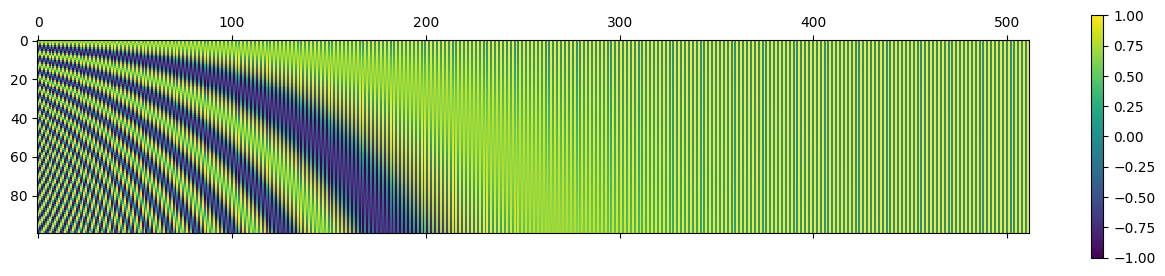

In [86]:
y = PositionalEncoder(512, 0.1, 100)
import numpy as np
import matplotlib.pyplot as plt
z = y.pe.squeeze(0)
cax = plt.matshow(z)
plt.gcf().colorbar(cax)

- **nn.Dropout演示**

In [87]:
m = nn.Dropout(p=0.2)
input = torch.randn(4, 5)
output = m(input)
print(output)
print(output.shape)

tensor([[ 0.1325, -2.8125,  0.9814,  0.2770,  0.6504],
        [ 1.2193, -0.1319,  0.9464,  1.7907,  0.4898],
        [-0.0000,  0.4363,  1.8478,  1.4398,  1.8312],
        [ 1.2365, -0.0000,  1.7039, -0.1966, -0.6068]])
torch.Size([4, 5])


- **torch.unsqueeze演示**

In [88]:
x=torch.tensor([1,2,3,4])
torch.unsqueeze(x,0)

tensor([[1, 2, 3, 4]])

In [89]:
torch.unsqueeze(x,1)

tensor([[1],
        [2],
        [3],
        [4]])

- **实例化参数**

In [90]:
# 词嵌入维度是512维
d_model = 512
 
# 置0比率为0.1
dropout = 0.1
 
# 句子最大长度
max_len=60

- **输入参数**

In [91]:
# 输入x是Embedding层的输出的张量, 形状是2 x 4 x 512
x = embr
x

tensor([[[ -4.6697,  -6.0534,  -5.2668,  ..., -11.8735, -23.0159,  27.3322],
         [  6.8467,  -3.4305,   3.6786,  ..., -19.7740, -31.9720, -12.3351],
         [  5.6094,   6.1216, -22.5410,  ...,   0.9803, -12.8439, -13.4272],
         [  6.2610,  12.3505,  15.3085,  ...,  16.1466, -35.5486,  32.2648]],

        [[-13.3856,  14.7171,  37.0112,  ...,   6.0940, -14.2405,   3.0835],
         [  8.0704, -10.3653, -29.4992,  ..., -31.5887, -48.9371, -10.0452],
         [  7.3509, -23.5942, -10.4161,  ...,  43.9306, -13.3478,  14.1981],
         [ -9.7556, -10.3625, -39.2270,  ...,   3.4950, -17.3911, -12.7946]]],
       grad_fn=<MulBackward0>)

- **调用与输出效果**

In [92]:
pe = PositionalEncoder(d_model, dropout, max_len)
pe_result = pe(x)
print("pe_result:", pe_result)
print(pe_result.shape)

pe_result: tensor([[[ -5.1886,  -5.6149,  -5.8520,  ..., -12.0817, -25.5732,   0.0000],
         [  8.5424,  -3.2114,   5.0006,  ..., -20.8600, -35.5244, -12.5946],
         [  0.0000,   6.3393,  -0.0000,  ...,   2.2003, -14.2708, -13.8080],
         [  7.1135,  12.6228,  17.2817,  ...,  19.0517, -39.4981,  36.9609]],

        [[-14.8729,  17.4635,  41.1236,  ...,   7.8822,  -0.0000,   4.5373],
         [  9.9021, -10.9167, -31.8638,  ..., -33.9875, -54.3744, -10.0503],
         [  9.1780, -26.6782, -10.5329,  ...,  49.9229,  -0.0000,  16.8867],
         [ -0.0000, -12.6139, -43.3133,  ...,   4.9944, -19.3231,  -0.0000]]],
       grad_fn=<MulBackward0>)
torch.Size([2, 4, 512])


- **绘制词汇向量中特征的分布曲线**

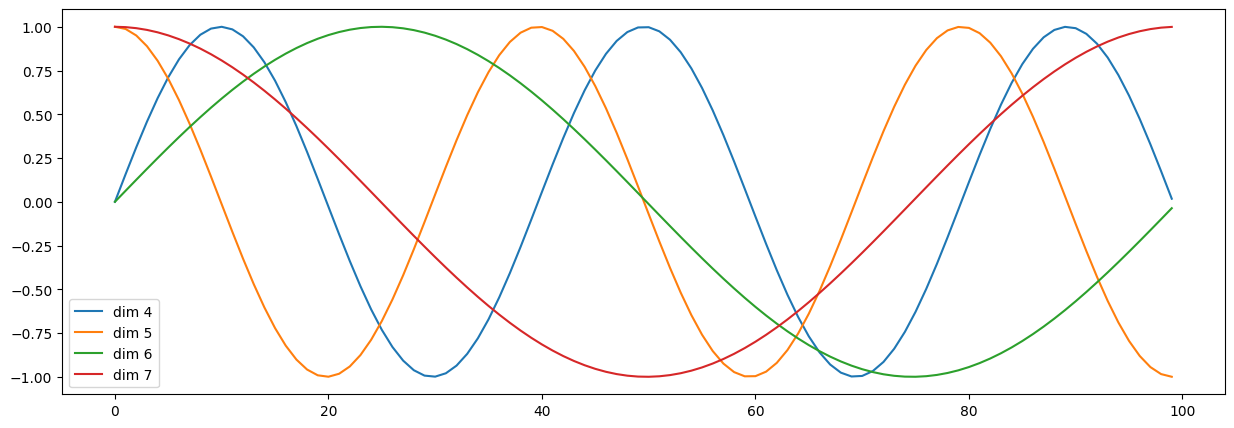

In [95]:
import matplotlib.pyplot as plt
import numpy as np
 
# 创建一张15 x 5大小的画布
plt.figure(figsize=(15, 5))
 
# 实例化PositionalEncoding类得到pe对象, 输入参数是20和0
pe = PositionalEncoder(20, 0)
 
# 然后向pe传入被Variable封装的tensor, 这样pe会直接执行forward函数, 
# 且这个tensor里的数值都是0, 被处理后相当于位置编码张量
y = pe(Variable(torch.zeros(1, 100, 20)))
 
# 然后定义画布的横纵坐标, 横坐标到100的长度, 纵坐标是某一个词汇中的某维特征在不同长度下对应的值
# 因为总共有20维之多, 我们这里只查看4，5，6，7维的值.
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
 
# 在画布上填写维度提示信息
plt.legend(["dim %d"%p for p in [4,5,6,7]])

## 三、多头注意力
多头注意力机制（Multi-Head Attention）是[Transformer模型](https://so.csdn.net/so/search?q=Transformer%E6%A8%A1%E5%9E%8B&spm=1001.2101.3001.7020)中的一个关键组件，用于处理序列数据，特别是在自然语言处理任务中。它的主要思想是将输入的查询（Query）、键（Key）和值（Value）通过多个独立的注意力头（Attention Heads）进行处理，然后将这些头的输出拼接起来并通过一个线性层进行整合。这种机制可以捕捉序列中不同位置的多种复杂关系。

以下是对多头注意力机制的详细解释：

**1. 初始化**
- `d_model`: 输入和输出的维度
- `heads`: 注意力头的数量
- `d_k`: 注意力头的维度，计算方式`d_model//heads`
- 线性层：用于将输入的`query`、`key`和`value`分别映射到`d_model`维度
- 丢弃层(Dropout): 用于防止过拟合
- 输出线性层：用于将拼接后的多头注意力输出映射回`d_model`维度

**2. 注意力计算**
- `attention`方法计算注意力分数。首先，通过矩阵策划嗯法计算`query`和`key`的点积，然后除以$\sqrt{d\_k}$进行缩放，以防止梯度消失或爆炸
- 如果提供了掩码(mask)，则将掩码中为0的位置对应的分数设置为一个非常小的值（如`-1e9`），以确保这些位置在`softmax`后为0
- 对分数进行`softmax`操作，使其成为一个概率分布
- 应用丢弃层(Dropout)

**3. 前向传播**
- 对输入的`query`、`key`和`value`分别进行线性变换，然后重塑为多头形式
- 将这些张量进行置换，以便在注意力计算中正确对齐
- 调用`attention`方法计算多头注意力
- 将多头注意力的输出进行转置和拼接，然后通过输出线性层进行整合

以下是完整的代码实现：

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_model//heads
        self.h = heads
        self.q_linear = nn.linear(d_model, d_model)
        self.v_linear = nn.linear(d_model, d_model)
        self.k_linear = nn.linear(d_model, d_model)
        self.dropoutt = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def attention(self, q, k, v, d_k, mask=None, dropout=None):
        scores = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(d_k)
        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask==0, -1e9)
        scores = F.softmask(scores)
        if dropout is not None:
            scores = dropout(scores)
        output = torch.matmul(scores, v)
        return output

    def forward(self, q, k, v, mask=None):
        bs = q.size(0)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k).transpose(1,2)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k).transpose(1,2)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k).transpose(1,2)
        scores = self.attention(q, k, v, self.d_k, maks, self.dropout)
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        output = self.out(concat)
        return output
        

转置操作`transpose(1,2)`是为了在多头注意力计算中正确对齐每个头的`query`、`key`和`value`，指的是，矩阵计算在`sequence_length`,`d_k`这两个维度上进行

## 四、前馈神经网络(FeedForward)和层归一化(NormLayer)

**FeedForward模块**

FeedForward模块是一个简单的前馈神经网络，通常紧跟在多头注意力机制之后。它由两个线性层和一个激活函数组成，中间包含一个丢弃层(Dropout)以防止过拟合。

**代码解析**

In [2]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear1(x)))
        x = self.linear2(x)
        return x

- **初始化**
    - `d_model`: 输入和输出的维度
    - `d_ff`: 中间层的维度，默认值设置为2048
    - `dropout`：丢弃层，默认值设为0.1
    - `self.linear1`：第一个线性层，将输入从`d_model`维度映射到`d_ff`维度
    - `self.dropout`：丢弃层，用于防止过拟合
    - `self.linear2`：第二个线性层，将输入从`d_ff`维度映射回`d_model`维度
- **前向传播**
    - `self.linear1(x)`: 将输入`x`从`d_model`维度映射到`d_ff`维度
    - `F.relu(self.linear1(x))`: 应用`ReLU`激活函数
    - `self.dropout(F.relu(self.linear1(x)))`: 应用丢弃层
    - `self.linear2(x)`: 将输入从`d_ff`维度映射会`d_model`维度

**NormLayer模块**

NormLayer模块是一层归一化曾，用于对输入进行归一化处理。层归一化通过对每个样本的所有特征进行归一化，是的每个样本的特征具有相同的均值和方差。

层归一化(Layer Normalization)的公式如下：
$$
\text{Norm}\left(x\right)=\alpha \cdot \left(\frac{x-\mu}{\sigma+\epsilon}\right)+\beta
$$
**代码解析**

In [7]:
class NormLayer(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(),__init__()
        self.size = d_model
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x-x.mean(dim=-1, keepdim=True))/(x.std(dim=-1,keepdim=True))+self.bias
        return norm

- **初始化**
    - `d_model`: 输入和输出的维度
    - `eps`: 一个很小的数，用于防止除0错误，默认设置为1e-6
    - `self.alpha`: 一个可学习的缩放参数，初始化为全1
    - `self.bias`：一个科学系的偏移参数，初始化为全0
- **前向传播**
    - `x.mean(dim=-1,keepdim=True)`: 计算输入`x`在最后一个维度上的均值
    - `x.std(dim=-1,keepdim=True)`: 计算输入`x`在最后一个维度上的标准差
    - `(x.mean(dim=-1,keepdim=True)) / (x.std(dim=-1,keepdim=True) + self.eps)`: 对输入`x`进行归一化处理
    - `x.std(dim=-1,keepdim=True)`: 计算输入`x`在最后一个维度上的标准差
    - `self.alpha * ... + self.bias`：应用可学习的缩放和偏移参数
这两个模块在Transformer模块中通常一起使用，FeedForward模块用于增加模型的非线性能力，而NormLayer模块用于稳定训练过程和加速收敛